### Data Exploration - Bureau Data

### Cash Data

Step 7: Our performance numbers using application_train and bureau data are still dismal.  We'll look at the POS_Cash data next.

### Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display # Allows the use of display() for DataFrames
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer

# Show all of the data in a dataframe
pd.set_option('display.max_columns', None)

### Load Data

In [11]:
# Training Set
application_train = pd.read_csv('data/tmp/application_train_reduced.csv', index_col=0)

print("Loaded Training Set: {0} rows {1} columns".format(application_train.shape[0], application_train.shape[1]))

cash_data = pd.read_csv('data/POS_CASH_balance.csv')
print("Loaded Cash Set: {0} rows".format(cash_data.shape[0]))

Loaded Training Set: 307511 rows 41 columns
Loaded Cash Set: 10001358 rows


In [12]:
non_numeric_features = []    # non-numeric features for one-hot encoding
numeric_features = []        # numeric features (for feature scaling)
string_to_bool_features = [] # boolean features (that need conversion from string to binary)
log_transform_features = []  # skewed features that need log transformation

### Inspect Data

#### Application Data

In [13]:
display(application_train.head(n=10))

,EXT_SOURCE_3,EXT_SOURCE_2,LOG_AMT_CREDIT,LOG_AMT_GOODS_PRICE,LOG_AMT_ANNUITY,DAYS_EMPLOYED,DAYS_BIRTH,EXT_SOURCE_1,DAYS_ID_PUBLISH,DAYS_REGISTRATION,LOG_OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,CODE_GENDER_M,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 2,REGION_POPULATION_RELATIVE,ORGANIZATION_TYPE_Transport: type 3,FLAG_DOCUMENT_16,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_13,LOG_DAYS_LAST_PHONE_CHANGE,ORGANIZATION_TYPE_Realtor,FLAG_DOCUMENT_18,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,ORGANIZATION_TYPE_Construction,HOUR_APPR_PROCESS_START_17,OCCUPATION_TYPE_Core staff,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE_Cash loans,LOG_DEF_60_CNT_SOCIAL_CIRCLE,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_Municipal apartment,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Industry: type 9,TOTALAREA_MODE,BOOL_FLAG_OWN_CAR,AMT_REQ_CREDIT_BUREAU_QRT,SK_ID_CURR
0,0.155552,0.307542,0.489166,0.839250,0.811714,0.211374,0.888839,0.086255,0.705433,0.852140,0.000000,2,1,0,0,0.256321,0,0,0,0,0.964087,0,0,1,0,0,0,0,1,1,0.341303,0,0,0,0,0,0,0.0149,0,0.000000,100002
1,0.000000,0.727773,0.746352,0.916069,0.841268,0.204632,0.477114,0.323330,0.959566,0.951929,0.000000,1,0,0,0,0.045016,0,0,0,0,0.974890,0,0,1,0,0,0,1,0,1,0.000000,1,0,1,0,0,0,0.0714,0,0.000000,100003
2,0.814240,0.650190,0.244144,0.776447,0.707614,0.216416,0.348534,0.000000,0.648326,0.827335,0.728879,2,1,0,0,0.134897,0,0,0,0,0.975328,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0.0000,1,0.000000,100004
3,0.000000,0.760751,0.430800,0.828270,0.826469,0.181984,0.350846,0.000000,0.661387,0.601451,0.000000,2,0,0,0,0.107023,0,0,0,0,0.981807,0,0,1,0,0,1,0,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.000000,100006
4,0.000000,0.377472,0.540824,0.864193,0.801931,0.181996,0.298591,0.000000,0.519522,0.825268,0.000000,2,1,0,0,0.392880,0,0,0,0,0.965117,0,0,0,0,0,0,1,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.000000,100007
5,0.693326,0.414298,0.530855,0.856235,0.820381,0.199738,0.467193,0.000000,0.933722,0.798557,0.000000,2,1,0,0,0.491595,0,0,0,0,0.896135,0,0,1,0,0,0,0,0,1,0.000000,0,0,1,0,0,0,0.0000,0,0.003831,100008
6,0.549168,0.846784,0.788087,0.929946,0.852967,0.180870,0.645490,0.804786,0.913992,0.950835,0.639210,2,0,0,0,0.491595,0,0,0,0,0.947120,0,0,0,0,0,0,0,0,1,0.000000,1,0,1,0,0,0,0.0000,1,0.003831,100009
7,0.603403,0.835415,0.783668,0.936017,0.854457,0.213675,0.359583,0.000000,0.669446,0.813675,0.485919,3,1,0,0,0.039215,0,0,0,0,0.966428,0,0,1,0,0,0,0,0,1,0.000000,1,0,1,0,0,0,0.0000,1,0.000000,100010
8,0.838968,0.240640,0.693475,0.902119,0.836946,1.000000,0.289177,0.610095,0.511741,0.698970,0.000000,2,0,0,0,0.254009,0,0,0,0,1.000000,0,0,1,0,0,0,0,0,1,0.000000,0,0,1,0,0,0,0.0000,0,0.000000,100011
9,0.000000,0.873268,0.488291,0.848656,0.795771,0.194464,0.606539,0.000000,0.445324,0.414843,0.000000,2,1,0,0,0.268617,0,0,0,0,0.942295,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0.0000,0,0.000000,100012


#### POS Cash Data

In [14]:
display(cash_data.head(n=10))

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
5,2207092,342166,-32,12.0,12.0,Active,0,0
6,1110516,204376,-38,48.0,43.0,Active,0,0
7,1387235,153211,-35,36.0,36.0,Active,0,0
8,1220500,112740,-31,12.0,12.0,Active,0,0
9,2371489,274851,-32,24.0,16.0,Active,0,0


### Utility Functions

In [15]:
# Visualize the contents of a non-numeric column

def explore_non_numeric(field, showDetails=True):

    # Inspired By: 
    # https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array

    unique, counts = np.unique(field, return_counts=True)
    total_records = np.size(field)

    if (showDetails): 
        i = 0
        while i < np.size(unique): 
            percentage = (counts[i] / total_records) * 100
            print("Value: {0} Count: {1} Percentage: {2}".format(unique[i], counts[i], percentage))
            i += 1

    # Example code from: https://matplotlib.org/examples/pie_and_polar_charts/pie_demo_features.html
    fig1, ax1 = plt.subplots()
    ax1.pie(counts, labels=unique, autopct='%1.1f%%',shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [16]:
# Visualize the contents of a numeric column

def explore_numeric(field, showUnique=False, graphType="dist", bins=20, showMeanLines=True):     
    mean = np.mean(field)
    avg = np.average(field)
    
    # Take a look at the range
    print("Max: {0} Min: {1} Mean: {2} Avg: {3} Std: {4}".format(
    np.max(field),
    np.min(field),
    mean,
    avg,
    np.std(field)))

    # Unique Values
    # print("Values: {0}".format(application_train['CNT_CHILDREN'].unique()))

    if (showUnique): 
    
        unique, counts = np.unique(application_train['CNT_CHILDREN'], return_counts=True)
        total_records = np.size(application_train['CNT_CHILDREN'])

        i = 0
        while i < np.size(unique): 
            percentage = (counts[i] / total_records) * 100
            print("Value: {0} Count: {1} Percentage: {2}".format(unique[i], counts[i], percentage))
            i += 1

    # Examine distribution
    plt.figure(figsize=(15,10))
    plt.title("Distribution Graph")
    if (showMeanLines):
        plt.axvline(avg, color="red")    # Plot the average
        plt.axvline(mean, color="green") # Plot the mean
    
    if (graphType == "hist"): 
        sns.distplot(field,bins=bins)
    else: 
        sns.distplot(field)

### Original Fields
The unedited fields from POS_CASH_Data.  We'll need to use these to create features that we can combine with the application_train dataset.

#### MONTHS_BALANCE
Month of balance relative to application date (-1 means the information to the freshest monthly snapshot, 0 means the information at application - often it will be the same as -1 as many banks are not updating the information to Credit Bureau regularly )

Max: -1 Min: -96 Mean: -35.012587990550884 Avg: -35.012587990550884 Std: 26.066568664438982


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


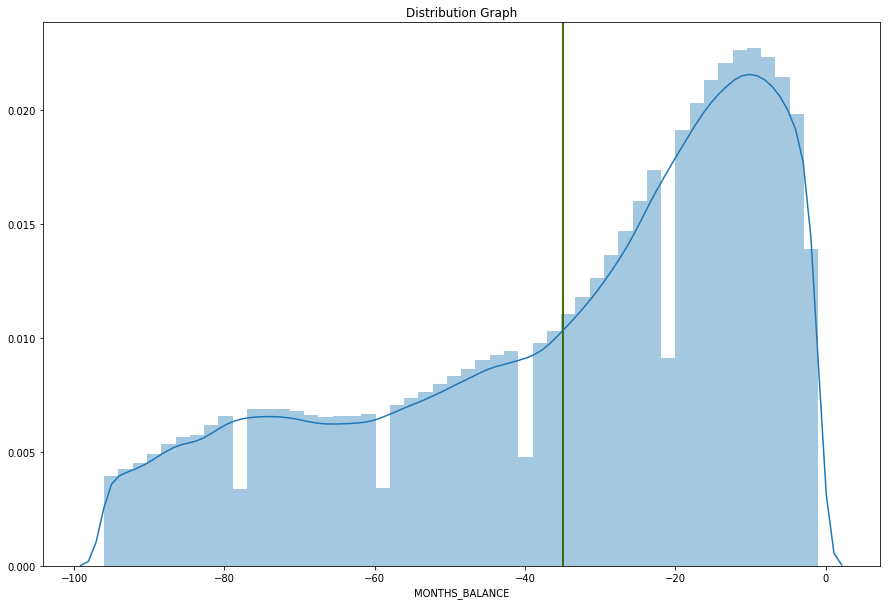

In [18]:
explore_numeric(cash_data['MONTHS_BALANCE'])

#### CNT_INSTALMENT
Term of previous credit (can change over time)

Max: 92.0 Min: 0.0 Mean: 17.045102075138196 Avg: 17.045102075138196 Std: 12.01106252814309


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


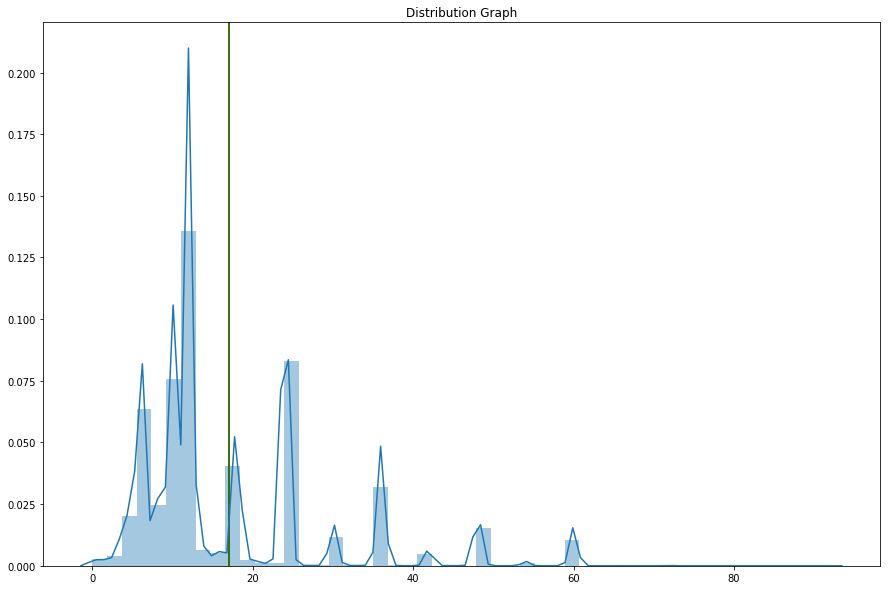

In [22]:
lb_make = LabelEncoder()
explore_numeric(np.nan_to_num(cash_data['CNT_INSTALMENT']))

#### CNT_INSTALMENT_FUTURE
Installments left to pay on the previous credit

Max: 85.0 Min: 0.0 Mean: 10.456494907991495 Avg: 10.456494907991495 Std: 11.107438446793033


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


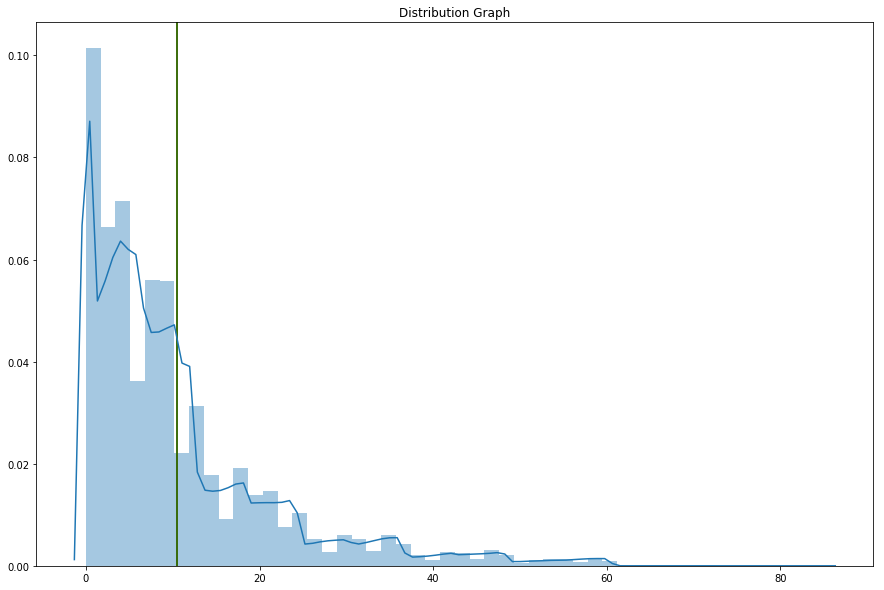

In [27]:
explore_numeric(np.nan_to_num(cash_data['CNT_INSTALMENT_FUTURE']))

#### NAME_CONTRACT_STATUS
Contract status during the month

Value: Active Count: 9151119 Percentage: 91.49876446778528
Value: Amortized debt Count: 636 Percentage: 0.006359136429272905
Value: Approved Count: 4917 Percentage: 0.04916332362065232
Value: Canceled Count: 15 Percentage: 0.0001499796327658704
Value: Completed Count: 744883 Percentage: 7.447818586235989
Value: Demand Count: 7065 Percentage: 0.07064040703272495
Value: Returned to the store Count: 5461 Percentage: 0.05460258496896122
Value: Signed Count: 87260 Percentage: 0.87248151700999
Value: XNA Count: 2 Percentage: 1.999728436878272e-05


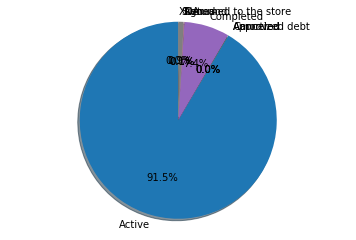

In [30]:
explore_non_numeric(cash_data['NAME_CONTRACT_STATUS']) 

#### SK_DPD
DPD (days past due) during the month of previous credit

Max: 4231 Min: 0 Mean: 11.606928279139693 Avg: 11.606928279139693 Std: 132.71403685829455


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


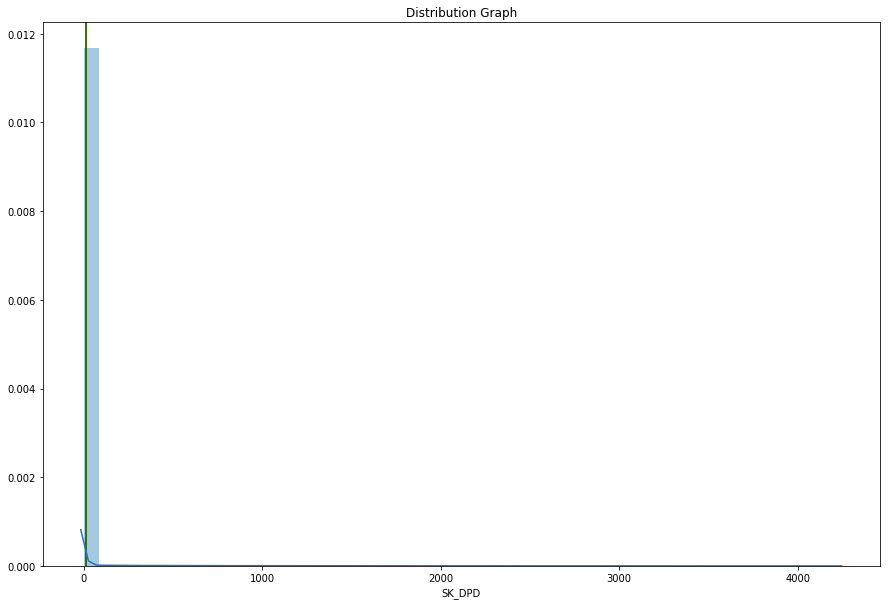

In [28]:
explore_numeric(cash_data['SK_DPD']) 

##### SK_DPD_DEF
DPD (Days past due) during the month with tolerance (debts with low loan amounts are ignored) of the previous credit

Max: 3595 Min: 0 Mean: 0.654468423188131 Avg: 0.654468423188131 Std: 32.762488906060405


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


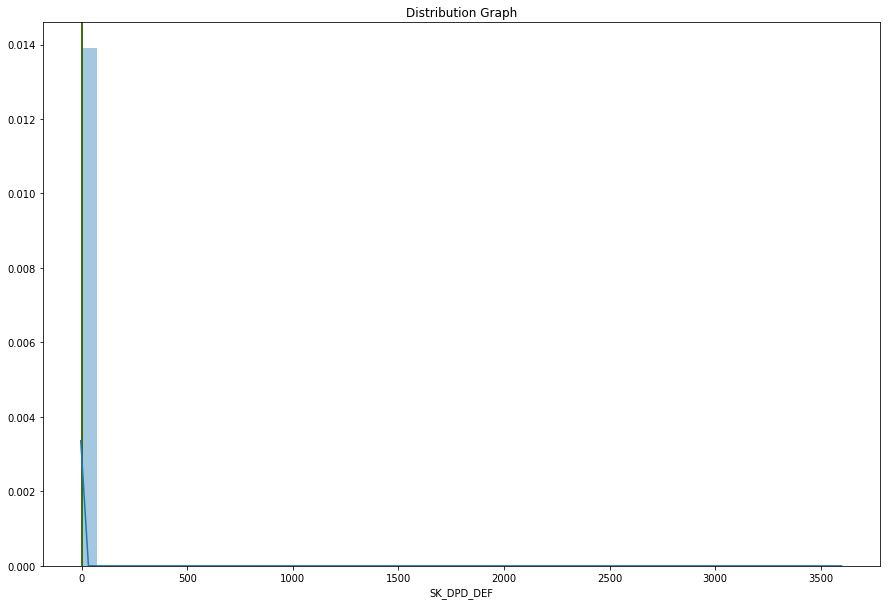

In [29]:
explore_numeric(cash_data['SK_DPD_DEF'])

### Feature Engineering

We have a situation where bureau_data has a one-to-many relationship with application_train, and bureau_balance_data has a one-to-many relationship with bureau_data; however, we need to present the data as a DataFrame to the classifier.

To accomplish this, we'll need to do a little feature engineering.

### One-Hot Encode Non Numeric Features

If we one-hot encode the non-numeric features, we can create aggregate counts for the application_data table.

In [29]:
# One-Hot Encode all of our non-numeric features
bureau_data = pd.get_dummies(bureau_data, columns=non_numeric_features)

print("Bureau Data Columns: {0}".format(bureau_data.shape[1]))

Bureau Data Columns: 40


In [30]:
bureau_balance_data = pd.get_dummies(bureau_balance_data, columns=['STATUS'])

print("Bureau Balance Data Columns: {0}".format(bureau_balance_data.shape[1]))

Bureau Balance Data Columns: 10


In [31]:
display(application_train.head())
display(bureau_data.head())
display(bureau_balance_data.head())

### Empty these out.  We're processing a different set of data now. 

non_numeric_features = []    # non-numeric features for one-hot encoding
numeric_features = []        # numeric features (for feature scaling)
string_to_bool_features = [] # boolean features (that need conversion from string to binary)
log_transform_features = []  # skewed features that need log transformation

,EXT_SOURCE_3,EXT_SOURCE_2,LOG_AMT_CREDIT,LOG_AMT_GOODS_PRICE,LOG_AMT_ANNUITY,DAYS_EMPLOYED,DAYS_BIRTH,EXT_SOURCE_1,DAYS_ID_PUBLISH,DAYS_REGISTRATION,LOG_OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,CODE_GENDER_M,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 2,REGION_POPULATION_RELATIVE,ORGANIZATION_TYPE_Transport: type 3,FLAG_DOCUMENT_16,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_13,LOG_DAYS_LAST_PHONE_CHANGE,ORGANIZATION_TYPE_Realtor,FLAG_DOCUMENT_18,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,ORGANIZATION_TYPE_Construction,HOUR_APPR_PROCESS_START_17,OCCUPATION_TYPE_Core staff,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE_Cash loans,LOG_DEF_60_CNT_SOCIAL_CIRCLE,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_Municipal apartment,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Industry: type 9,TOTALAREA_MODE,BOOL_FLAG_OWN_CAR,AMT_REQ_CREDIT_BUREAU_QRT,SK_ID_CURR
0,0.155552,0.307542,0.489166,0.839250,0.811714,0.211374,0.888839,0.086255,0.705433,0.852140,0.000000,2,1,0,0,0.256321,0,0,0,0,0.964087,0,0,1,0,0,0,0,1,1,0.341303,0,0,0,0,0,0,0.0149,0,0.0,100002
1,0.000000,0.727773,0.746352,0.916069,0.841268,0.204632,0.477114,0.323330,0.959566,0.951929,0.000000,1,0,0,0,0.045016,0,0,0,0,0.974890,0,0,1,0,0,0,1,0,1,0.000000,1,0,1,0,0,0,0.0714,0,0.0,100003
2,0.814240,0.650190,0.244144,0.776447,0.707614,0.216416,0.348534,0.000000,0.648326,0.827335,0.728879,2,1,0,0,0.134897,0,0,0,0,0.975328,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0.0000,1,0.0,100004
3,0.000000,0.760751,0.430800,0.828270,0.826469,0.181984,0.350846,0.000000,0.661387,0.601451,0.000000,2,0,0,0,0.107023,0,0,0,0,0.981807,0,0,1,0,0,1,0,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.0,100006
4,0.000000,0.377472,0.540824,0.864193,0.801931,0.181996,0.298591,0.000000,0.519522,0.825268,0.000000,2,1,0,0,0.392880,0,0,0,0,0.965117,0,0,0,0,0,0,1,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.0,100007


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_TYPE_CODE_0,CREDIT_TYPE_CODE_1,CREDIT_TYPE_CODE_2,CREDIT_TYPE_CODE_3,CREDIT_TYPE_CODE_4,CREDIT_TYPE_CODE_5,CREDIT_TYPE_CODE_6,CREDIT_TYPE_CODE_7,CREDIT_TYPE_CODE_8,CREDIT_TYPE_CODE_9,CREDIT_TYPE_CODE_10,CREDIT_TYPE_CODE_11,CREDIT_TYPE_CODE_12,CREDIT_TYPE_CODE_13,CREDIT_TYPE_CODE_14,CREDIT_ACTIVE_CODE_0,CREDIT_ACTIVE_CODE_1,CREDIT_ACTIVE_CODE_2,CREDIT_ACTIVE_CODE_3,CREDIT_CURRENCY_CODE_0,CREDIT_CURRENCY_CODE_1,CREDIT_CURRENCY_CODE_2,CREDIT_CURRENCY_CODE_3
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


### New Features

We'll engineer some new features to combine with the application_train data.

In [32]:
display(application_train.head())

new_features = application_train['SK_ID_CURR']
new_features = new_features.to_frame() 

display(new_features.head())

,EXT_SOURCE_3,EXT_SOURCE_2,LOG_AMT_CREDIT,LOG_AMT_GOODS_PRICE,LOG_AMT_ANNUITY,DAYS_EMPLOYED,DAYS_BIRTH,EXT_SOURCE_1,DAYS_ID_PUBLISH,DAYS_REGISTRATION,LOG_OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,CODE_GENDER_M,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 2,REGION_POPULATION_RELATIVE,ORGANIZATION_TYPE_Transport: type 3,FLAG_DOCUMENT_16,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_13,LOG_DAYS_LAST_PHONE_CHANGE,ORGANIZATION_TYPE_Realtor,FLAG_DOCUMENT_18,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,ORGANIZATION_TYPE_Construction,HOUR_APPR_PROCESS_START_17,OCCUPATION_TYPE_Core staff,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE_Cash loans,LOG_DEF_60_CNT_SOCIAL_CIRCLE,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_Municipal apartment,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Industry: type 9,TOTALAREA_MODE,BOOL_FLAG_OWN_CAR,AMT_REQ_CREDIT_BUREAU_QRT,SK_ID_CURR
0,0.155552,0.307542,0.489166,0.839250,0.811714,0.211374,0.888839,0.086255,0.705433,0.852140,0.000000,2,1,0,0,0.256321,0,0,0,0,0.964087,0,0,1,0,0,0,0,1,1,0.341303,0,0,0,0,0,0,0.0149,0,0.0,100002
1,0.000000,0.727773,0.746352,0.916069,0.841268,0.204632,0.477114,0.323330,0.959566,0.951929,0.000000,1,0,0,0,0.045016,0,0,0,0,0.974890,0,0,1,0,0,0,1,0,1,0.000000,1,0,1,0,0,0,0.0714,0,0.0,100003
2,0.814240,0.650190,0.244144,0.776447,0.707614,0.216416,0.348534,0.000000,0.648326,0.827335,0.728879,2,1,0,0,0.134897,0,0,0,0,0.975328,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0.0000,1,0.0,100004
3,0.000000,0.760751,0.430800,0.828270,0.826469,0.181984,0.350846,0.000000,0.661387,0.601451,0.000000,2,0,0,0,0.107023,0,0,0,0,0.981807,0,0,1,0,0,1,0,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.0,100006
4,0.000000,0.377472,0.540824,0.864193,0.801931,0.181996,0.298591,0.000000,0.519522,0.825268,0.000000,2,1,0,0,0.392880,0,0,0,0,0.965117,0,0,0,0,0,0,1,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.0,100007


,SK_ID_CURR
0,100002
1,100003
2,100004
3,100006
4,100007


### NUM_BUREAU_REPORTS
Number of bureau reports for a given SK_ID_CURR

In [33]:
num_reports = bureau_data.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()
df_num_reports = num_reports.to_frame().reset_index()

# Had a hard time getting this column named correctly... from:
# https://stackoverflow.com/questions/11346283/renaming-columns-in-pandas
df_num_reports.rename(columns={'SK_ID_BUREAU': 'NUM_BUREAU_REPORTS'}, inplace=True)

new_features = new_features.merge(df_num_reports, on='SK_ID_CURR')
display(new_features.head())

,SK_ID_CURR,NUM_BUREAU_REPORTS
0,100002,8
1,100003,4
2,100004,2
3,100007,1
4,100008,3


Max: 116 Min: 1 Mean: 5.56119563856071 Avg: 5.56119563856071 Std: 4.377888417769493


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


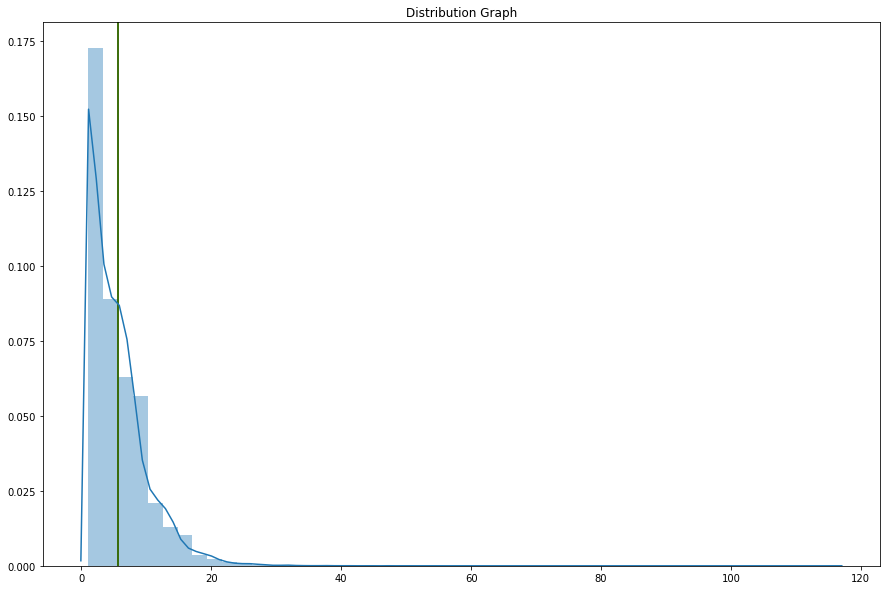

In [34]:
explore_numeric(np.nan_to_num(new_features["NUM_BUREAU_REPORTS"]))

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 4.762173934797756 Min: 0.6931471805599453 Mean: 1.6850041710985884 Avg: 1.6850041710985884 Std: 0.6266337055181641


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


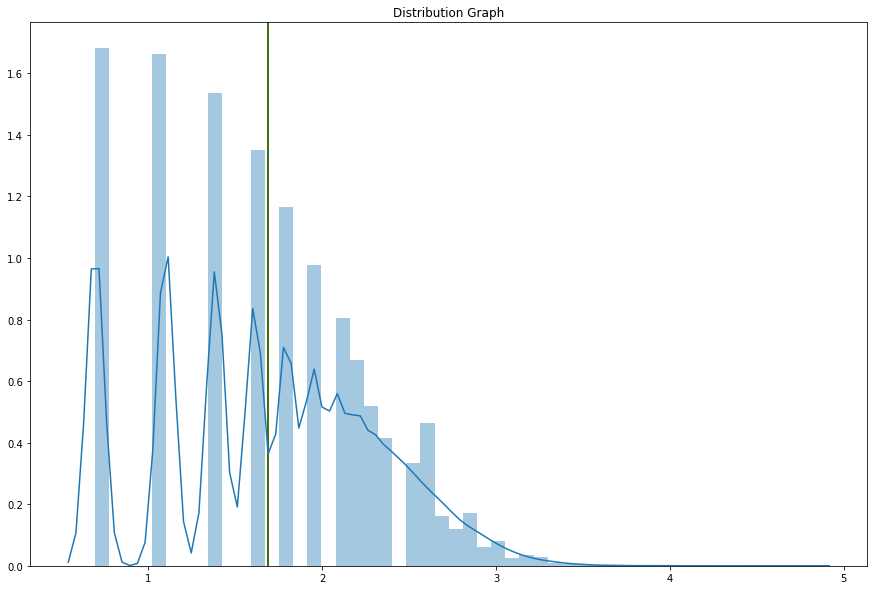

In [35]:
num_bureau_reports = new_features['NUM_BUREAU_REPORTS']
num_bureau_reports = num_bureau_reports.apply(lambda x: np.log(x + 1))
num_bureau_reports = np.nan_to_num(num_bureau_reports)

#visualize the new distribution
explore_numeric(num_bureau_reports)

log_transform_features.append('NUM_BUREAU_REPORTS')

### NUM_BUREAU_BALANCES
Number of balances recorded for a given SK_ID_CURR

In [36]:
num_balances = bureau_balance_data.groupby('SK_ID_BUREAU')['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'NUM_BUREAU_BALANCES'})
df_num_balances = pd.DataFrame(data=num_balances, columns=['NUM_BUREAU_BALANCES'])

bureau_data = bureau_data.merge(df_num_balances, on='SK_ID_BUREAU')
bureau_data['NUM_BUREAU_BALANCES'] = bureau_data['NUM_BUREAU_BALANCES'].fillna(0)

In [37]:
display(bureau_data.head())

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_TYPE_CODE_0,CREDIT_TYPE_CODE_1,CREDIT_TYPE_CODE_2,CREDIT_TYPE_CODE_3,CREDIT_TYPE_CODE_4,CREDIT_TYPE_CODE_5,CREDIT_TYPE_CODE_6,CREDIT_TYPE_CODE_7,CREDIT_TYPE_CODE_8,CREDIT_TYPE_CODE_9,CREDIT_TYPE_CODE_10,CREDIT_TYPE_CODE_11,CREDIT_TYPE_CODE_12,CREDIT_TYPE_CODE_13,CREDIT_TYPE_CODE_14,CREDIT_ACTIVE_CODE_0,CREDIT_ACTIVE_CODE_1,CREDIT_ACTIVE_CODE_2,CREDIT_ACTIVE_CODE_3,CREDIT_CURRENCY_CODE_0,CREDIT_CURRENCY_CODE_1,CREDIT_CURRENCY_CODE_2,CREDIT_CURRENCY_CODE_3,NUM_BUREAU_BALANCES
0,380361,5715448,Active,currency 1,-820,0,31069.0,NaN,NaN,0,67500.0,0.0,67500.0,0.0,Credit card,-183,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,27
1,380361,5715449,Active,currency 1,-357,0,1119.0,NaN,NaN,0,45000.0,0.0,45000.0,0.0,Credit card,-130,2691.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,12
2,380361,5715451,Closed,currency 1,-917,0,-187.0,-759.0,NaN,0,74439.0,0.0,0.0,0.0,Consumer credit,-748,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,26
3,380361,5715452,Closed,currency 1,-993,0,31039.0,-831.0,NaN,0,315000.0,0.0,0.0,0.0,Credit card,-818,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,33
4,380361,5715453,Closed,currency 1,-1146,0,681.0,-780.0,NaN,0,2025000.0,0.0,0.0,0.0,Consumer credit,-769,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,38


### SUM_BUREAU_BALANCES
Now that we have some data in bureau_data, we'll need to summate it for inclusion in the application_train set

,SK_ID_CURR,SUM_BUREAU_BALANCES
0,100001,172
1,100002,110
2,100005,21
3,100010,72
4,100013,230


,SK_ID_CURR,NUM_BUREAU_REPORTS,SUM_BUREAU_BALANCES
0,100002,8,110
1,100010,2,72
2,100019,2,34
3,100032,4,76
4,100033,1,7


Max: 2657 Min: 1 Mean: 159.3998980819898 Avg: 159.3998980819898 Std: 159.19079926225214


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


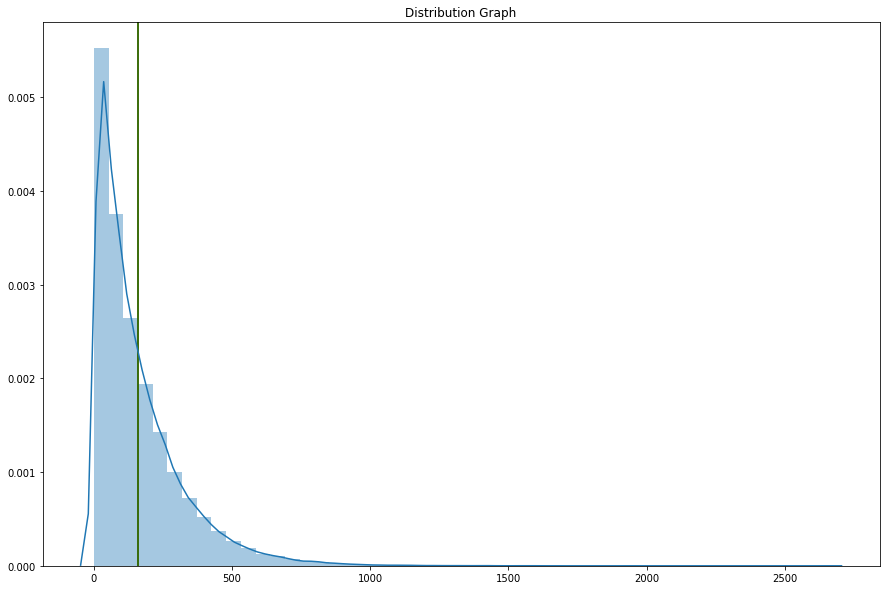

In [38]:
sum_balances = bureau_data.groupby('SK_ID_CURR')['NUM_BUREAU_BALANCES'].sum()

df_sum_balances = sum_balances.to_frame().reset_index()
df_sum_balances.rename(columns={'NUM_BUREAU_BALANCES': 'SUM_BUREAU_BALANCES'}, inplace=True)

display(df_sum_balances.head())

new_features = new_features.merge(df_sum_balances, on='SK_ID_CURR')

display(new_features.head())

explore_numeric(np.nan_to_num(new_features['SUM_BUREAU_BALANCES']))

numeric_features.append('SUM_BUREAU_BALANCES')

### MONTHS_BALANCE


NOTE: We really need to group the MONTHS_BALANCE value by STATUS in order for it to be meaningful, since a closed account with a 60 month balance is pretty different than a default account with a 60 month balance, or a late, open account with a 2 month balance.

### SUM_CURRENCY_CODE

In [39]:
num_codes = 4
credit_active_codes = []

for i in range(0, num_codes): 
    credit_active_codes.append('CREDIT_CURRENCY_CODE_{0}'.format(i))

for code in credit_active_codes: 

    sum_code = bureau_data.groupby('SK_ID_CURR')[code].sum().rename(columns = {'SK_ID_CURR': code})

    new_code = 'SUM_{0}'.format(code)
    df_sum_code = pd.DataFrame(data=sum_code, columns=[new_code])

    new_features = new_features.merge(df_sum_code, on='SK_ID_CURR')
    new_features[new_code] = new_features[new_code].fillna(0)

    numeric_features.append(new_code)     


Max: 6 Min: 0 Mean: 0.0035129186499116348 Avg: 0.0035129186499116348 Std: 0.07867324035188096


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


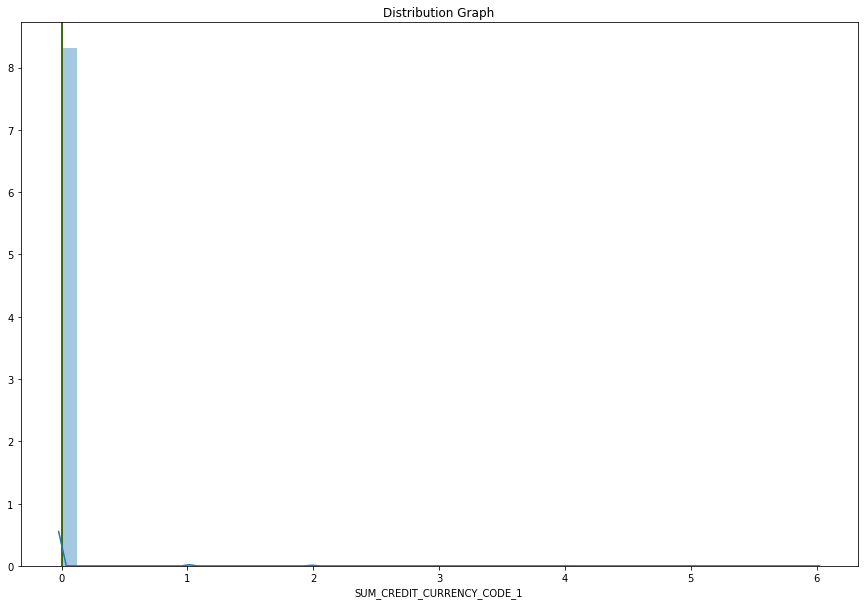

In [40]:
explore_numeric(new_features['SUM_CREDIT_CURRENCY_CODE_1'])

### SUM_CREDIT_ACTIVE_CODE

In [41]:
num_codes = 4
credit_active_codes = []

for i in range(0, num_codes): 
    credit_active_codes.append('CREDIT_ACTIVE_CODE_{0}'.format(i))

for code in credit_active_codes: 

    sum_code = bureau_data.groupby('SK_ID_CURR')[code].sum().rename(columns = {'SK_ID_CURR': code})

    new_code = 'SUM_{0}'.format(code)
    df_sum_code = pd.DataFrame(data=sum_code, columns=[new_code])

    new_features = new_features.merge(df_sum_code, on='SK_ID_CURR')           
    new_features[new_code] = new_features[new_code].fillna(0)

    numeric_features.append(new_code)     

,SK_ID_CURR,NUM_BUREAU_REPORTS,SUM_BUREAU_BALANCES,SUM_CREDIT_CURRENCY_CODE_0,SUM_CREDIT_CURRENCY_CODE_1,SUM_CREDIT_CURRENCY_CODE_2,SUM_CREDIT_CURRENCY_CODE_3,SUM_CREDIT_ACTIVE_CODE_0,SUM_CREDIT_ACTIVE_CODE_1,SUM_CREDIT_ACTIVE_CODE_2,SUM_CREDIT_ACTIVE_CODE_3
0,100002,8,110,8,0,0,0,2,0,6,0
1,100010,2,72,2,0,0,0,1,0,1,0
2,100019,2,34,2,0,0,0,2,0,0,0
3,100032,4,76,4,0,0,0,1,0,3,0
4,100033,1,7,1,0,0,0,1,0,0,0


Max: 5 Min: 0 Mean: 0.02230269649033405 Avg: 0.02230269649033405 Std: 0.16040640213833265


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


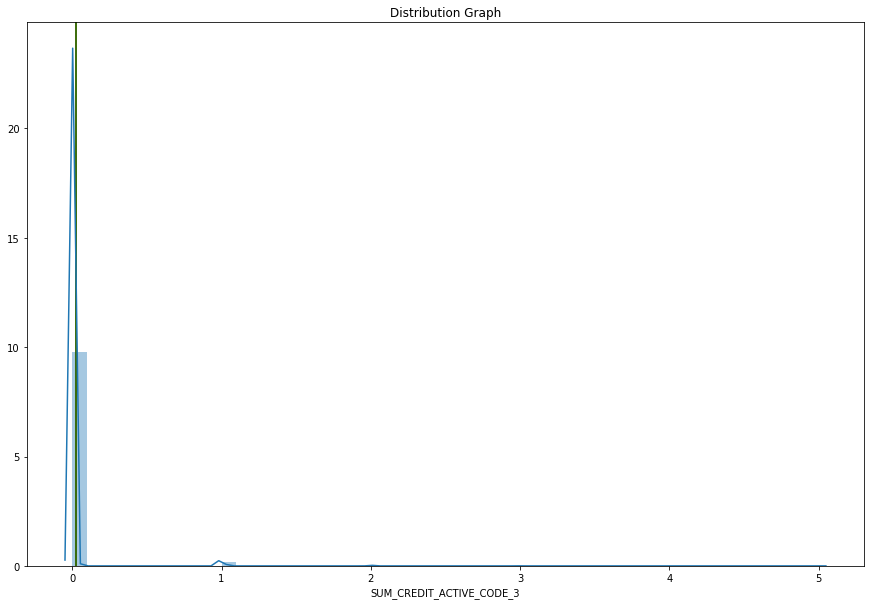

In [42]:
display(new_features.head())
explore_numeric(new_features['SUM_CREDIT_ACTIVE_CODE_3'])

### SUM_CREDIT_TYPE_CODE
Number of balances with a status of 0 recorded for a given SK_ID_BUREAU

In [43]:
num_codes = 15
credit_type_codes = []

for i in range(0, num_codes): 
    credit_type_codes.append('CREDIT_TYPE_CODE_{0}'.format(i))

for code in credit_type_codes: 

    sum_code = bureau_data.groupby('SK_ID_CURR')[code].sum().rename(columns = {'SK_ID_CURR': code})

    new_code = 'SUM_{0}'.format(code)
    df_sum_code = pd.DataFrame(data=sum_code, columns=[new_code])

    new_features = new_features.merge(df_sum_code, on='SK_ID_CURR')
    new_features[new_code] = new_features[new_code].fillna(0)
    
    numeric_features.append(new_code)                

,SK_ID_CURR,NUM_BUREAU_REPORTS,SUM_BUREAU_BALANCES,SUM_CREDIT_CURRENCY_CODE_0,SUM_CREDIT_CURRENCY_CODE_1,SUM_CREDIT_CURRENCY_CODE_2,SUM_CREDIT_CURRENCY_CODE_3,SUM_CREDIT_ACTIVE_CODE_0,SUM_CREDIT_ACTIVE_CODE_1,SUM_CREDIT_ACTIVE_CODE_2,SUM_CREDIT_ACTIVE_CODE_3,SUM_CREDIT_TYPE_CODE_0,SUM_CREDIT_TYPE_CODE_1,SUM_CREDIT_TYPE_CODE_2,SUM_CREDIT_TYPE_CODE_3,SUM_CREDIT_TYPE_CODE_4,SUM_CREDIT_TYPE_CODE_5,SUM_CREDIT_TYPE_CODE_6,SUM_CREDIT_TYPE_CODE_7,SUM_CREDIT_TYPE_CODE_8,SUM_CREDIT_TYPE_CODE_9,SUM_CREDIT_TYPE_CODE_10,SUM_CREDIT_TYPE_CODE_11,SUM_CREDIT_TYPE_CODE_12,SUM_CREDIT_TYPE_CODE_13,SUM_CREDIT_TYPE_CODE_14
0,100002,8,110,8,0,0,0,2,0,6,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0
1,100010,2,72,2,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
2,100019,2,34,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
3,100032,4,76,4,0,0,0,1,0,3,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
4,100033,1,7,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Max: 18 Min: 0 Mean: 1.3205755114874609 Avg: 1.3205755114874609 Std: 1.5078538480324162


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


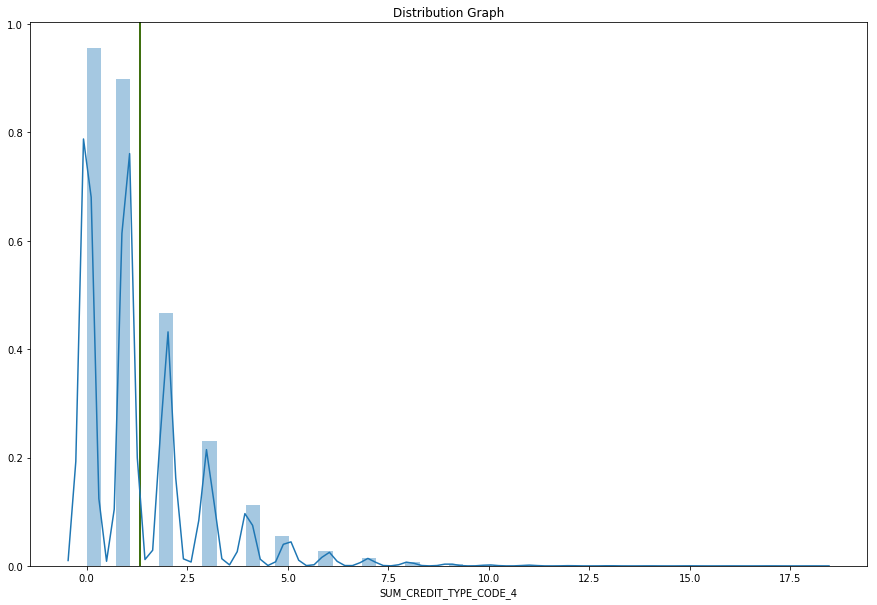

In [44]:
display(new_features.head())
explore_numeric(new_features['SUM_CREDIT_TYPE_CODE_4'])

### SUM_STATUS_X
Number of balances with a status of "x" recorded for a given SK_ID_BUREAU

In [45]:
# All of the possible values for bureau_balance_data.STATUS
codes = ['0','1','2','3','4','5','C','X']

for code in codes: 
    
    cur_code = "STATUS_" + code
    fin_code = "SUM_STATUS_" + code
    
    
    # Count all of the instances of this status code in bureau_balance_data into the corresponding bureau_data record
    sum_status = bureau_balance_data.groupby('SK_ID_BUREAU')[cur_code].sum().rename(columns = {'SK_ID_BUREAU': cur_code})
    
    
    df_sum_status = pd.DataFrame(data=sum_status, columns=[cur_code])
    
    # Summate the count across all corresponding SK_ID_BUREAUs and create a record for each application
    bureau_data = bureau_data.merge(df_sum_status, on='SK_ID_BUREAU')
    bureau_data[cur_code] = bureau_data[cur_code].fillna(0)

    # Merge it into a new dataframe
    sum_all_status = bureau_data.groupby('SK_ID_CURR')[cur_code].sum().rename(columns = {'SK_ID_CURR': fin_code})
    df_sum_all_status = pd.DataFrame(data=sum_all_status, columns=[fin_code])

    new_features = new_features.merge(df_sum_all_status, on='SK_ID_CURR')

    numeric_features.append(fin_code)

In [46]:
display(bureau_balance_data.head())
display(bureau_data.head())
display(new_features.head())

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,5715448,0,0,0,0,0,0,0,1,0
1,5715448,-1,0,0,0,0,0,0,1,0
2,5715448,-2,0,0,0,0,0,0,1,0
3,5715448,-3,0,0,0,0,0,0,1,0
4,5715448,-4,0,0,0,0,0,0,1,0


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_TYPE_CODE_0,CREDIT_TYPE_CODE_1,CREDIT_TYPE_CODE_2,CREDIT_TYPE_CODE_3,CREDIT_TYPE_CODE_4,CREDIT_TYPE_CODE_5,CREDIT_TYPE_CODE_6,CREDIT_TYPE_CODE_7,CREDIT_TYPE_CODE_8,CREDIT_TYPE_CODE_9,CREDIT_TYPE_CODE_10,CREDIT_TYPE_CODE_11,CREDIT_TYPE_CODE_12,CREDIT_TYPE_CODE_13,CREDIT_TYPE_CODE_14,CREDIT_ACTIVE_CODE_0,CREDIT_ACTIVE_CODE_1,CREDIT_ACTIVE_CODE_2,CREDIT_ACTIVE_CODE_3,CREDIT_CURRENCY_CODE_0,CREDIT_CURRENCY_CODE_1,CREDIT_CURRENCY_CODE_2,CREDIT_CURRENCY_CODE_3,NUM_BUREAU_BALANCES,STATUS_0,STATUS_1,STATUS_2,STATUS_3,STATUS_4,STATUS_5,STATUS_C,STATUS_X
0,380361,5715448,Active,currency 1,-820,0,31069.0,NaN,NaN,0,67500.0,0.0,67500.0,0.0,Credit card,-183,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,27,8,0,0,0,0,0,9,10
1,380361,5715449,Active,currency 1,-357,0,1119.0,NaN,NaN,0,45000.0,0.0,45000.0,0.0,Credit card,-130,2691.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,12,5,0,0,0,0,0,6,1
2,380361,5715451,Closed,currency 1,-917,0,-187.0,-759.0,NaN,0,74439.0,0.0,0.0,0.0,Consumer credit,-748,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,26,17,0,0,0,0,0,5,4
3,380361,5715452,Closed,currency 1,-993,0,31039.0,-831.0,NaN,0,315000.0,0.0,0.0,0.0,Credit card,-818,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,33,8,0,0,0,0,0,15,10
4,380361,5715453,Closed,currency 1,-1146,0,681.0,-780.0,NaN,0,2025000.0,0.0,0.0,0.0,Consumer credit,-769,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,38,8,0,0,0,0,0,20,10


,SK_ID_CURR,NUM_BUREAU_REPORTS,SUM_BUREAU_BALANCES,SUM_CREDIT_CURRENCY_CODE_0,SUM_CREDIT_CURRENCY_CODE_1,SUM_CREDIT_CURRENCY_CODE_2,SUM_CREDIT_CURRENCY_CODE_3,SUM_CREDIT_ACTIVE_CODE_0,SUM_CREDIT_ACTIVE_CODE_1,SUM_CREDIT_ACTIVE_CODE_2,SUM_CREDIT_ACTIVE_CODE_3,SUM_CREDIT_TYPE_CODE_0,SUM_CREDIT_TYPE_CODE_1,SUM_CREDIT_TYPE_CODE_2,SUM_CREDIT_TYPE_CODE_3,SUM_CREDIT_TYPE_CODE_4,SUM_CREDIT_TYPE_CODE_5,SUM_CREDIT_TYPE_CODE_6,SUM_CREDIT_TYPE_CODE_7,SUM_CREDIT_TYPE_CODE_8,SUM_CREDIT_TYPE_CODE_9,SUM_CREDIT_TYPE_CODE_10,SUM_CREDIT_TYPE_CODE_11,SUM_CREDIT_TYPE_CODE_12,SUM_CREDIT_TYPE_CODE_13,SUM_CREDIT_TYPE_CODE_14,SUM_STATUS_0,SUM_STATUS_1,SUM_STATUS_2,SUM_STATUS_3,SUM_STATUS_4,SUM_STATUS_5,SUM_STATUS_C,SUM_STATUS_X
0,100002,8,110,8,0,0,0,2,0,6,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0,45.0,27,0,0,0,0.0,23.0,15.0
1,100010,2,72,2,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,20.0,0,0,0,0,0.0,52.0,0.0
2,100019,2,34,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,32.0,0,0,0,0,0.0,0.0,2.0
3,100032,4,76,4,0,0,0,1,0,3,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,68.0,0,0,0,0,0.0,0.0,8.0
4,100033,1,7,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0.0,0.0,6.0


### MED_DAYS_CREDIT

The median number of days before current application that client apply for Credit Bureau credit, across all available credit bureau reports.

In [47]:
days_credit = bureau_data.groupby('SK_ID_CURR')['DAYS_CREDIT'].median().rename(columns = {'SK_ID_CURR': 'MED_DAYS_CREDIT'})
df_days_credit = pd.DataFrame(data=days_credit, columns=['MED_DAYS_CREDIT'])
new_features = new_features.merge(df_days_credit, on='SK_ID_CURR')

numeric_features.append('MED_DAYS_CREDIT')

Max: -2.0 Min: -2922.0 Mean: -1021.9590538972797 Avg: -1021.9590538972797 Std: 600.6613116202043


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


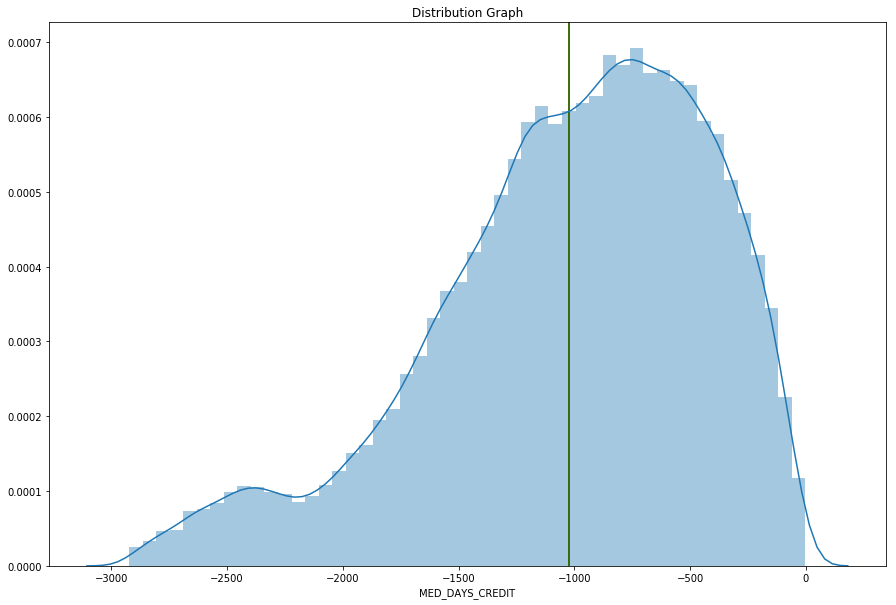

In [48]:
explore_numeric(new_features['MED_DAYS_CREDIT'])

### SUM_CREDIT_DAYS_OVERDUE

Total days of overdue credit across all bureau reports.

In [49]:
credit_day_overdue = bureau_data.groupby('SK_ID_CURR')['CREDIT_DAY_OVERDUE'].sum().rename(columns = {'SK_ID_CURR': 'SUM_CREDIT_DAYS_OVERDUE'})
df_credit_day_overdue = pd.DataFrame(data=credit_day_overdue, columns=['SUM_CREDIT_DAYS_OVERDUE'])
new_features = new_features.merge(df_credit_day_overdue, on='SK_ID_CURR')

numeric_features.append('SUM_CREDIT_DAYS_OVERDUE')

Max: 5134 Min: 0 Mean: 3.375155858659236 Avg: 3.375155858659236 Std: 73.91593731005518


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


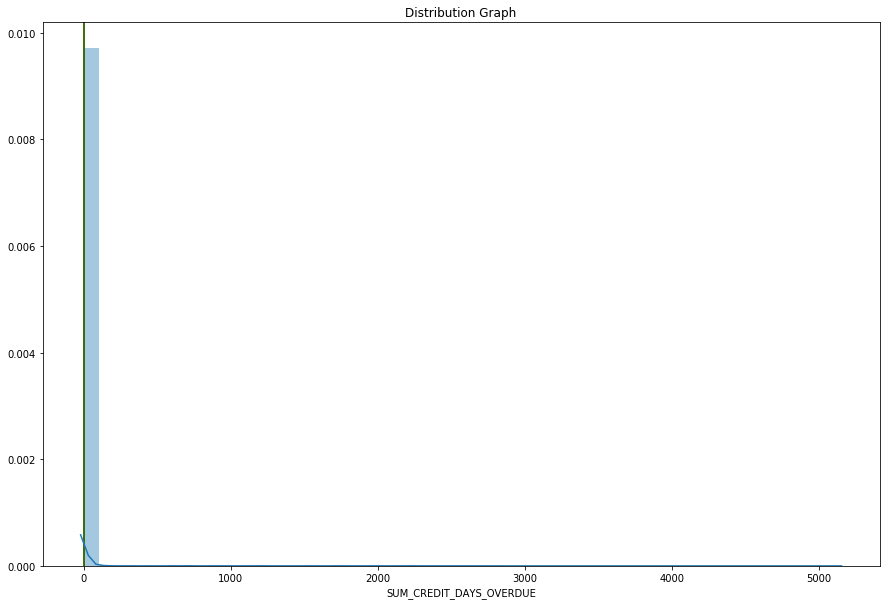

In [50]:
explore_numeric(new_features['SUM_CREDIT_DAYS_OVERDUE'])

### SUM_CREDIT_DAYS_ENDDATE
Remaining duration of CB credit (in days) at the time of application in Home Credit

In [51]:
credit_days_enddate = bureau_data.groupby('SK_ID_CURR')['DAYS_CREDIT_ENDDATE'].sum().rename(columns = {'SK_ID_CURR': 'SUM_DAYS_CREDIT_ENDDATE'})
df_credit_days_enddate = pd.DataFrame(data=credit_days_enddate, columns=['SUM_DAYS_CREDIT_ENDDATE'])
new_features = new_features.merge(df_credit_days_enddate, on='SK_ID_CURR')

numeric_features.append('SUM_DAYS_CREDIT_ENDDATE')

Max: 214193.0 Min: -49075.0 Mean: 3298.662900760048 Avg: 3298.662900760048 Std: 13257.902311120442


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


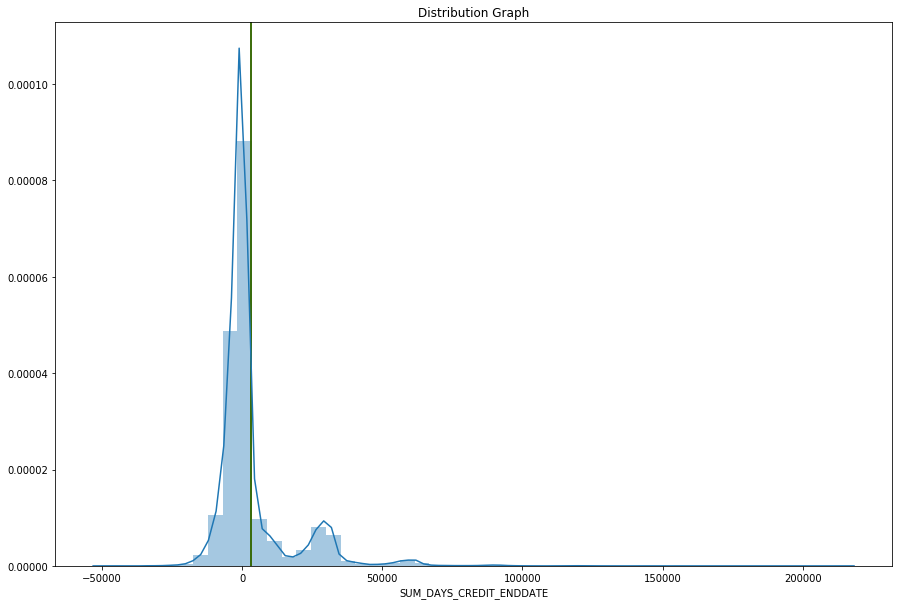

In [52]:
explore_numeric(new_features['SUM_DAYS_CREDIT_ENDDATE'])

### SUM_DAYS_ENDDATE_FACT
Days since CB credit ended at the time of application in Home Credit (only for closed credit)

In [53]:
days_enddate_fact = bureau_data.groupby('SK_ID_CURR')['DAYS_ENDDATE_FACT'].sum().rename(columns = {'SK_ID_CURR': 'SUM_DAYS_ENDDATE_FACT'})
df_days_enddate_fact = pd.DataFrame(data=days_enddate_fact, columns=['SUM_DAYS_ENDDATE_FACT'])
new_features = new_features.merge(df_days_enddate_fact, on='SK_ID_CURR')

numeric_features.append('SUM_DAYS_ENDDATE_FACT')

Max: 0.0 Min: -61740.0 Mean: -3510.2830718521973 Avg: -3510.2830718521973 Std: 4002.461852632849


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


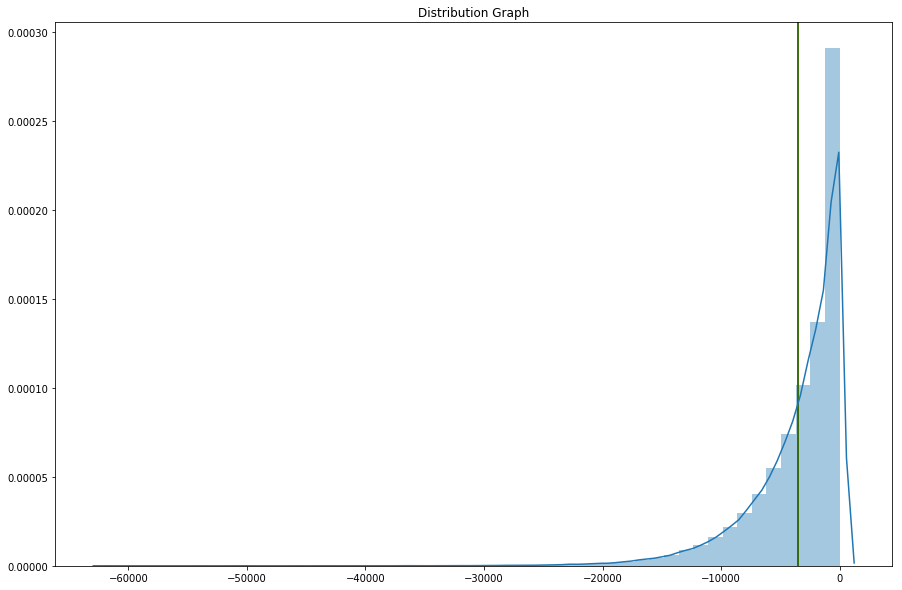

In [54]:
explore_numeric(np.nan_to_num(new_features['SUM_DAYS_ENDDATE_FACT']))

### SUM_AMT_CREDIT_MAX_OVERDUE
Maximal amount overdue on the Credit Bureau credit so far (at application date of loan in our sample)

In [55]:
credit_max_overdue = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].sum().rename(columns = {'SK_ID_CURR': 'SUM_AMT_CREDIT_MAX_OVERDUE'})
df_credit_max_overdue = pd.DataFrame(data=credit_max_overdue, columns=['SUM_AMT_CREDIT_MAX_OVERDUE'])
new_features = new_features.merge(df_credit_max_overdue, on='SK_ID_CURR')

Max: 115987185.0 Min: 0.0 Mean: 8087.8715683447 Avg: 8087.8715683447 Std: 498221.1467473202


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


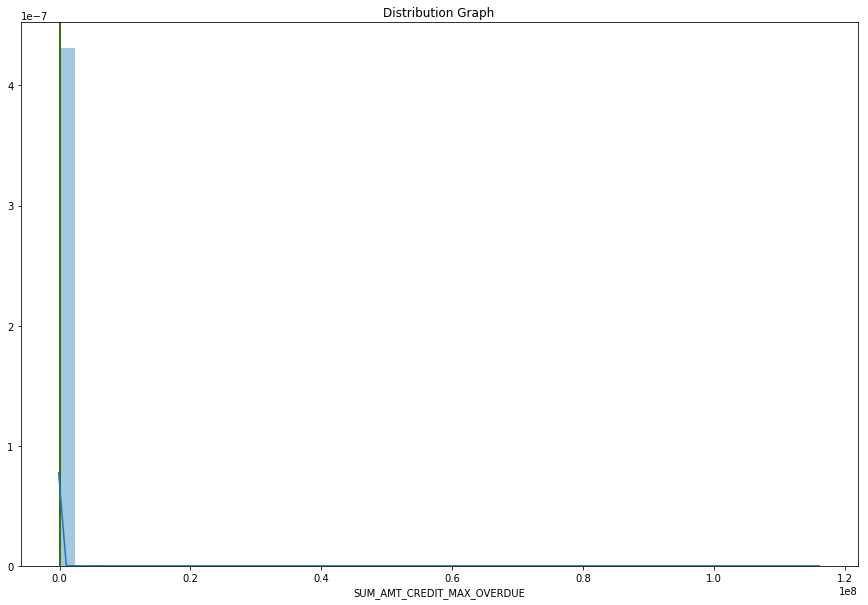

In [56]:
explore_numeric(new_features['SUM_AMT_CREDIT_MAX_OVERDUE'])

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 18.568990277451633 Min: 0.0 Mean: 2.128310380161785 Avg: 2.128310380161785 Std: 3.908081426401892


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


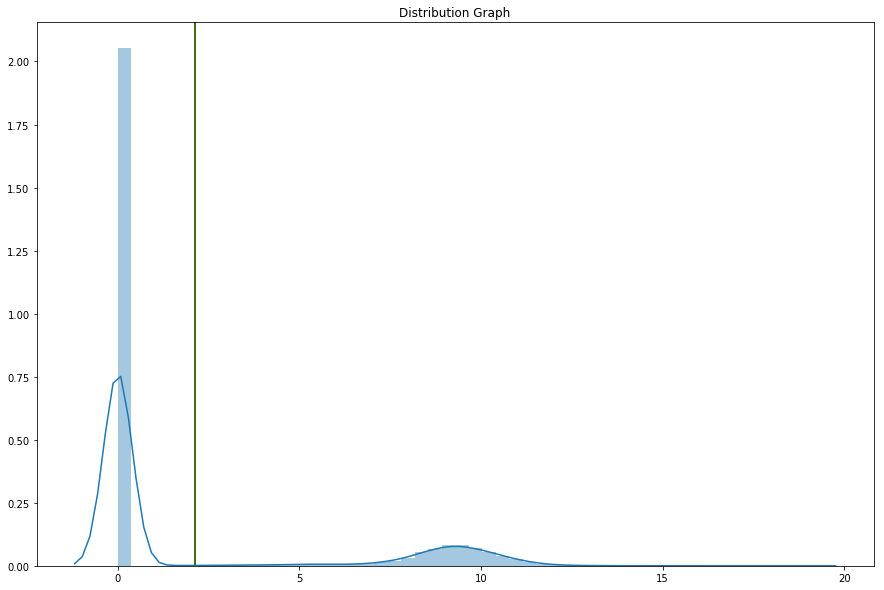

In [57]:
credit_max_overdue = new_features['SUM_AMT_CREDIT_MAX_OVERDUE']
credit_max_overdue = credit_max_overdue.apply(lambda x: np.log(x + 1))
credit_max_overdue = np.nan_to_num(credit_max_overdue, copy=True)

#visualize the new distribution
explore_numeric(credit_max_overdue)

log_transform_features.append('SUM_AMT_CREDIT_MAX_OVERDUE')

### SUM_CNT_CREDIT_PROLONG
How many times was the Credit Bureau credit prolonged

In [58]:
cnt_credit_prolong = bureau_data.groupby('SK_ID_CURR')['CNT_CREDIT_PROLONG'].sum().rename(columns = {'SK_ID_CURR': 'SUM_CNT_CREDIT_PROLONG'})
df_cnt_credit_prolong = pd.DataFrame(data=cnt_credit_prolong, columns=['SUM_CNT_CREDIT_PROLONG'])
new_features = new_features.merge(df_cnt_credit_prolong, on='SK_ID_CURR')

Max: 9 Min: 0 Mean: 0.041927334627186084 Avg: 0.041927334627186084 Std: 0.25537275134817056


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


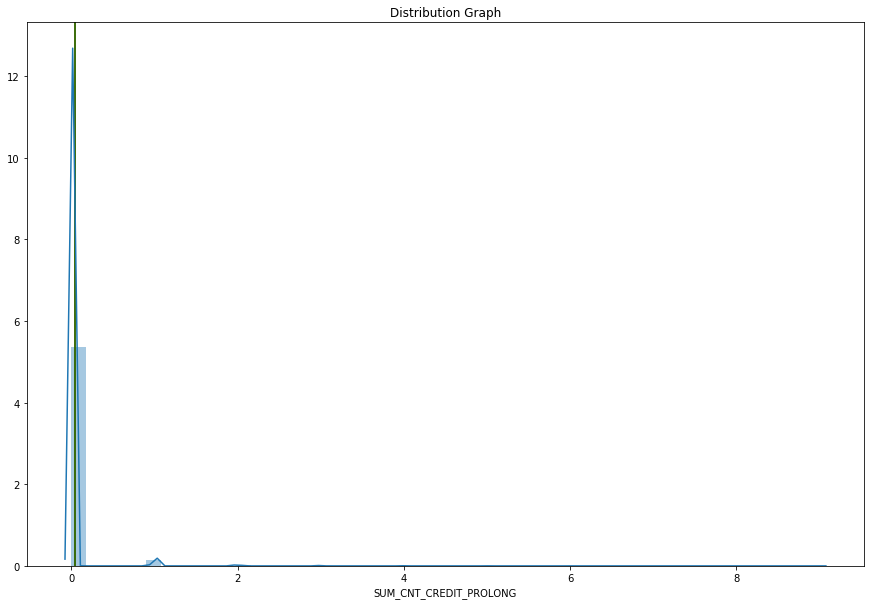

In [59]:
explore_numeric(new_features['SUM_CNT_CREDIT_PROLONG'])
numeric_features.append('SUM_CNT_CREDIT_PROLONG')

### SUM_AMT_CREDIT_SUM
Current credit amount for the Credit Bureau credit

In [60]:
amt_credit_sum = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum().rename(columns = {'SK_ID_CURR': 'SUM_AMT_CREDIT_SUM'})
df_amt_credit_sum = pd.DataFrame(data=amt_credit_sum, columns=['SUM_AMT_CREDIT_SUM'])
new_features = new_features.merge(df_amt_credit_sum, on='SK_ID_CURR')

Max: 471622517.46000004 Min: 0.0 Mean: 2086333.6264027497 Avg: 2086333.6264027497 Std: 3893015.6319138394


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


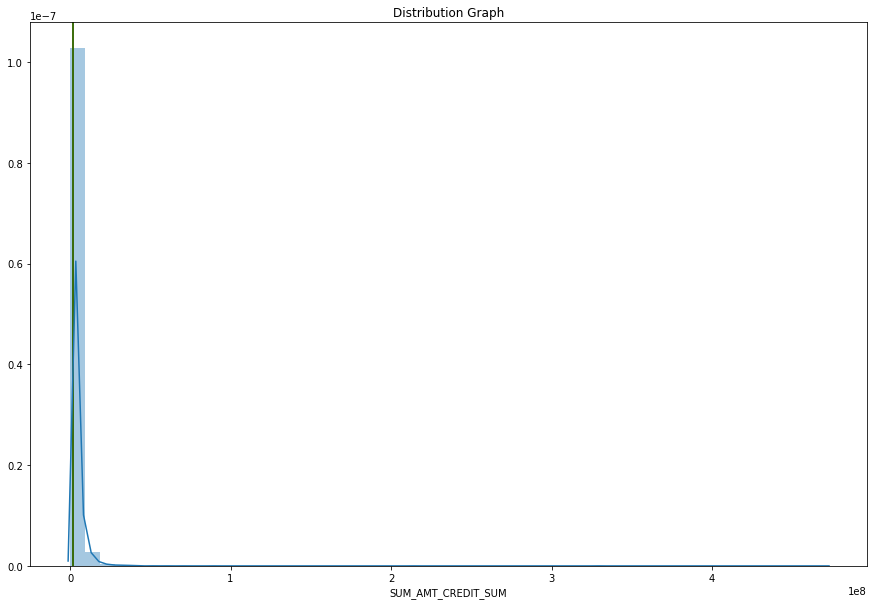

In [61]:
explore_numeric(new_features['SUM_AMT_CREDIT_SUM'])

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 19.971689474554545 Min: 0.0 Mean: 13.672249762111342 Avg: 13.672249762111342 Std: 1.6614851297125857


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


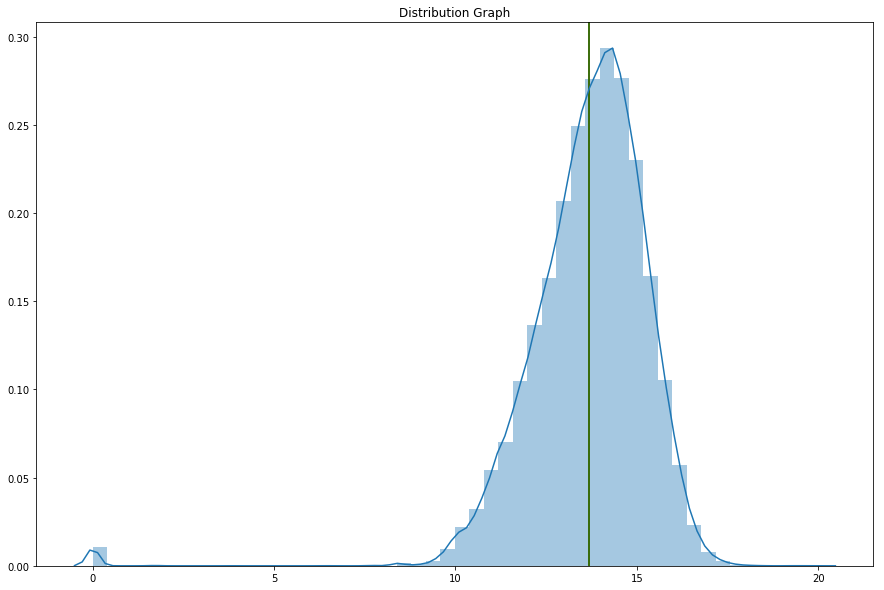

In [62]:
amt_credit_sum = new_features['SUM_AMT_CREDIT_SUM']
amt_credit_sum = amt_credit_sum.apply(lambda x: np.log(x + 1))
amt_credit_sum = np.nan_to_num(amt_credit_sum, copy=True)

#visualize the new distribution
explore_numeric(amt_credit_sum)

log_transform_features.append('SUM_AMT_CREDIT_SUM')

### SUM_AMT_CREDIT_SUM_DEBT
Current debt on Credit Bureau credit

In [63]:
amt_credit_sum_debt = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum().rename(columns = {'SK_ID_CURR': 'SUM_AMT_CREDIT_SUM_DEBT'})
df_amt_credit_sum_debt = pd.DataFrame(data=amt_credit_sum_debt, columns=['SUM_AMT_CREDIT_SUM_DEBT'])
new_features = new_features.merge(df_amt_credit_sum_debt, on='SK_ID_CURR')

Max: 334498331.20500004 Min: -1999478.475 Mean: 701263.8487294511 Avg: 701263.8487294511 Std: 1896001.633632184


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


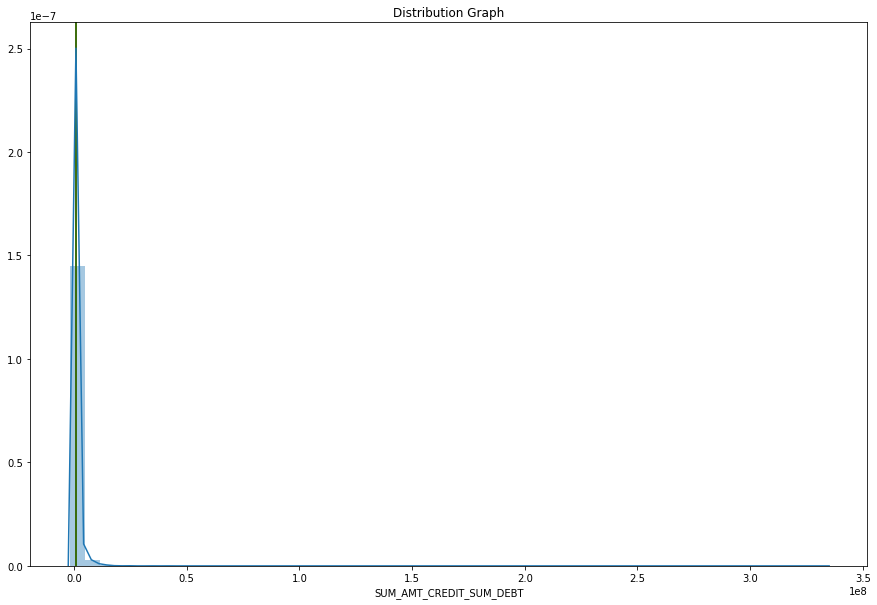

In [64]:
explore_numeric(new_features['SUM_AMT_CREDIT_SUM_DEBT'])

#### Preprocessing: 
This feature is skewed right, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 19.628142451585898 Min: -0.6831968497067772 Mean: 9.255479152418317 Avg: 9.255479152418317 Std: 5.905479271753752


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


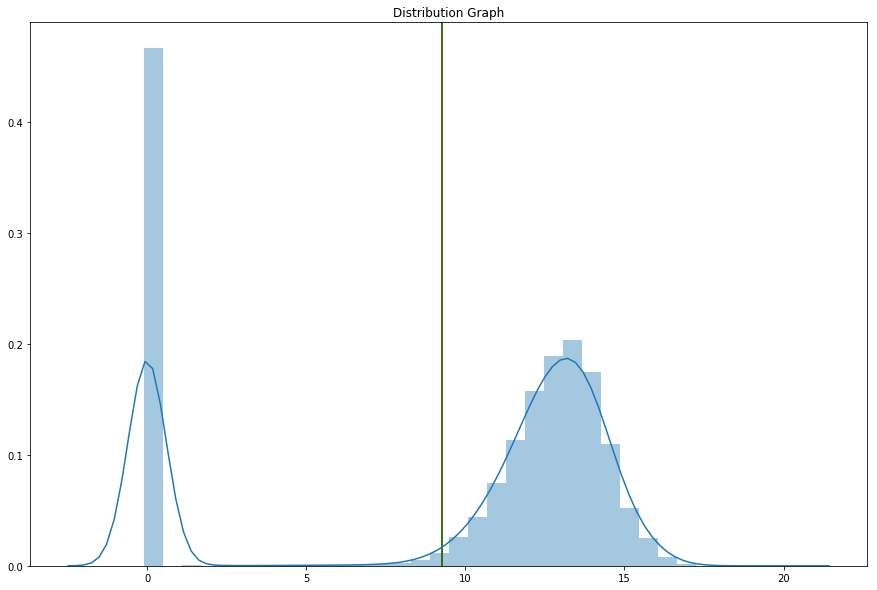

In [65]:
amt_credit_sum = new_features['SUM_AMT_CREDIT_SUM_DEBT']
amt_credit_sum = amt_credit_sum.apply(lambda x: np.log(x + 1))
amt_credit_sum = np.nan_to_num(amt_credit_sum, copy=True)

#visualize the new distribution
explore_numeric(amt_credit_sum)

log_transform_features.append('SUM_AMT_CREDIT_SUM_DEBT')

### SUM_AMT_CREDIT_SUM_LIMIT
Current credit limit of credit card reported in Credit Bureau

In [66]:
amt_credit_sum_limit = bureau_data.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].sum().rename(columns = {'SK_ID_CURR': 'SUM_AMT_CREDIT_SUM_LIMIT'})
df_amt_credit_sum_limit = pd.DataFrame(data=amt_credit_sum_limit, columns=['SUM_AMT_CREDIT_SUM_LIMIT'])
new_features = new_features.merge(df_amt_credit_sum_limit, on='SK_ID_CURR')

Max: 6412500.0 Min: -579854.115 Mean: 19812.152361559565 Avg: 19812.152361559565 Std: 88959.82608514922


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


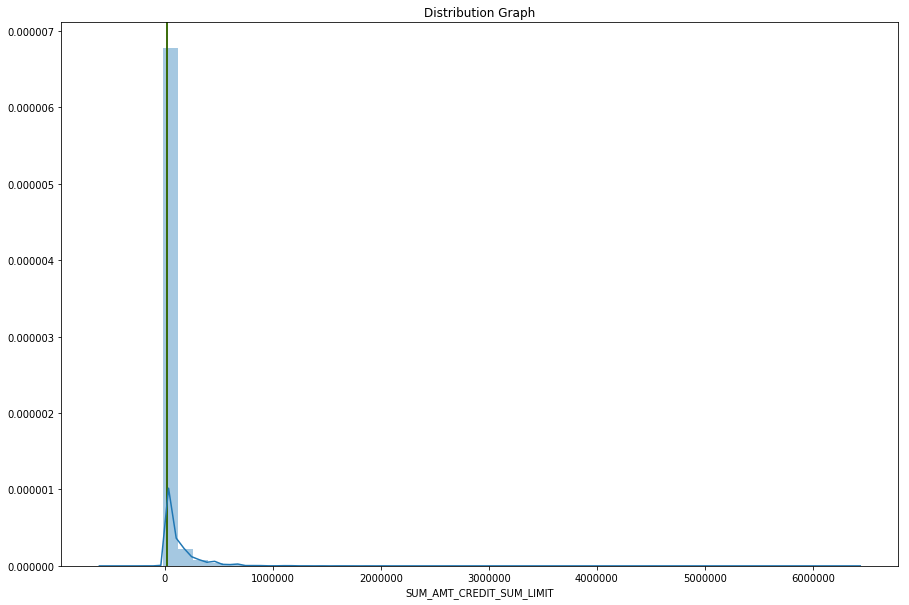

In [67]:
explore_numeric(new_features['SUM_AMT_CREDIT_SUM_LIMIT'])

#### Preprocessing: 
This feature is skewed left, in that we have a large number of values near zero, and body of other values distributed across the range.

It's common to do a log transformation for fields like this. The result looks normally distributed.

Max: 15.67375992440657 Min: 0.0 Mean: 1.8181465143948101 Avg: 1.8181465143948101 Std: 4.036439398420052


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


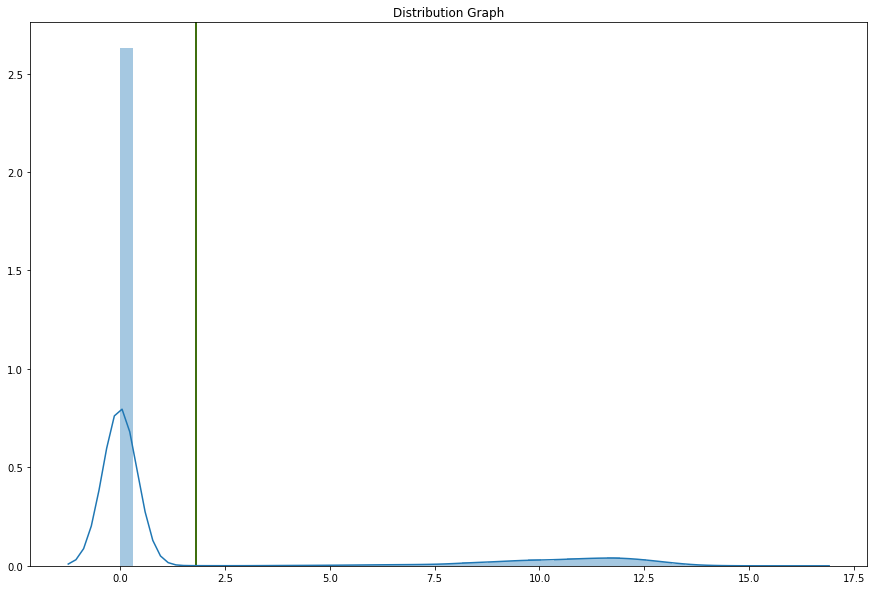

In [68]:
amt_credit_sum = new_features['SUM_AMT_CREDIT_SUM_LIMIT']
amt_credit_sum = amt_credit_sum.apply(lambda x: np.log(x + 1))
amt_credit_sum = np.nan_to_num(amt_credit_sum, copy=True)

#visualize the new distribution
explore_numeric(amt_credit_sum)

log_transform_features.append('SUM_AMT_CREDIT_SUM_LIMIT')

### SUM_DAYS_CREDIT_UPDATE
How many days before loan application did last information about the Credit Bureau creditt

In [69]:
days_credit_update = bureau_data.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].sum().rename(columns = {'SK_ID_CURR': 'SUM_DAYS_CREDIT_UPDATE'})
df_days_credit_update = pd.DataFrame(data=days_credit_update, columns=['SUM_DAYS_CREDIT_UPDATE'])
new_features = new_features.merge(df_days_credit_update, on='SK_ID_CURR')

Max: 0 Min: -86851 Mean: -3147.7361733039866 Avg: -3147.7361733039866 Std: 3551.858912543587


/Users/jeclark/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


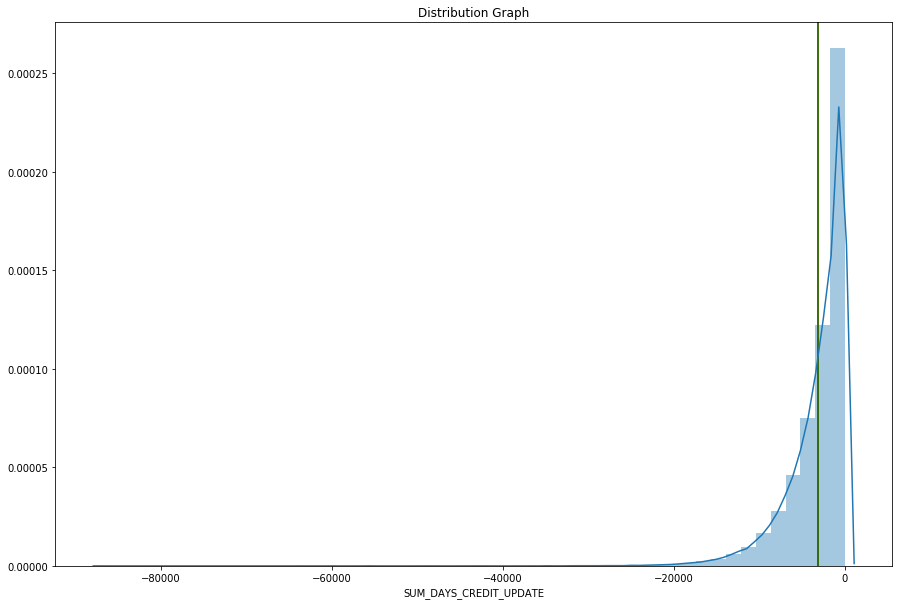

In [70]:
explore_numeric(new_features['SUM_DAYS_CREDIT_UPDATE'])
numeric_features.append('SUM_DAYS_CREDIT_UPDATE')

#### Merge New Features to Bureau Data

In [71]:
display(new_features.head()) 

application_train_merged = application_train.merge(new_features, on='SK_ID_CURR', how='left')

display(application_train_merged.head())

print(application_train_merged.shape)

,SK_ID_CURR,NUM_BUREAU_REPORTS,SUM_BUREAU_BALANCES,SUM_CREDIT_CURRENCY_CODE_0,SUM_CREDIT_CURRENCY_CODE_1,SUM_CREDIT_CURRENCY_CODE_2,SUM_CREDIT_CURRENCY_CODE_3,SUM_CREDIT_ACTIVE_CODE_0,SUM_CREDIT_ACTIVE_CODE_1,SUM_CREDIT_ACTIVE_CODE_2,SUM_CREDIT_ACTIVE_CODE_3,SUM_CREDIT_TYPE_CODE_0,SUM_CREDIT_TYPE_CODE_1,SUM_CREDIT_TYPE_CODE_2,SUM_CREDIT_TYPE_CODE_3,SUM_CREDIT_TYPE_CODE_4,SUM_CREDIT_TYPE_CODE_5,SUM_CREDIT_TYPE_CODE_6,SUM_CREDIT_TYPE_CODE_7,SUM_CREDIT_TYPE_CODE_8,SUM_CREDIT_TYPE_CODE_9,SUM_CREDIT_TYPE_CODE_10,SUM_CREDIT_TYPE_CODE_11,SUM_CREDIT_TYPE_CODE_12,SUM_CREDIT_TYPE_CODE_13,SUM_CREDIT_TYPE_CODE_14,SUM_STATUS_0,SUM_STATUS_1,SUM_STATUS_2,SUM_STATUS_3,SUM_STATUS_4,SUM_STATUS_5,SUM_STATUS_C,SUM_STATUS_X,MED_DAYS_CREDIT,SUM_CREDIT_DAYS_OVERDUE,SUM_DAYS_CREDIT_ENDDATE,SUM_DAYS_ENDDATE_FACT,SUM_AMT_CREDIT_MAX_OVERDUE,SUM_CNT_CREDIT_PROLONG,SUM_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_LIMIT,SUM_DAYS_CREDIT_UPDATE
0,100002,8,110,8,0,0,0,2,0,6,0,0,0,0,4,4,0,0,0,0,0,0,0,0,0,0,45.0,27,0,0,0,0.0,23.0,15.0,-1042.5,0,-2094.0,-4185.0,8405.145,0,865055.565,245781.00,31988.565,-3999
1,100010,2,72,2,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,20.0,0,0,0,0,0.0,52.0,0.0,-1939.5,0,-239.0,-1138.0,0.000,0,990000.000,348007.50,0.000,-1156
2,100019,2,34,2,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,32.0,0,0,0,0,0.0,0.0,2.0,-495.0,0,10882.0,0.0,0.000,0,720000.000,245470.14,270000.000,-53
3,100032,4,76,4,0,0,0,1,0,3,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,68.0,0,0,0,0,0.0,0.0,8.0,-1169.5,0,-2101.0,-1910.0,0.000,0,1271160.000,0.00,0.000,-1747
4,100033,1,7,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0.0,0.0,6.0,-195.0,0,913.0,0.0,0.000,0,675000.000,0.00,0.000,-169


,EXT_SOURCE_3,EXT_SOURCE_2,LOG_AMT_CREDIT,LOG_AMT_GOODS_PRICE,LOG_AMT_ANNUITY,DAYS_EMPLOYED,DAYS_BIRTH,EXT_SOURCE_1,DAYS_ID_PUBLISH,DAYS_REGISTRATION,LOG_OWN_CAR_AGE,REGION_RATING_CLIENT_W_CITY,CODE_GENDER_M,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 2,REGION_POPULATION_RELATIVE,ORGANIZATION_TYPE_Transport: type 3,FLAG_DOCUMENT_16,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_13,LOG_DAYS_LAST_PHONE_CHANGE,ORGANIZATION_TYPE_Realtor,FLAG_DOCUMENT_18,FLAG_DOCUMENT_3,FLAG_DOCUMENT_6,ORGANIZATION_TYPE_Construction,HOUR_APPR_PROCESS_START_17,OCCUPATION_TYPE_Core staff,NAME_INCOME_TYPE_Working,NAME_CONTRACT_TYPE_Cash loans,LOG_DEF_60_CNT_SOCIAL_CIRCLE,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_FAMILY_STATUS_Married,NAME_HOUSING_TYPE_Municipal apartment,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Industry: type 9,TOTALAREA_MODE,BOOL_FLAG_OWN_CAR,AMT_REQ_CREDIT_BUREAU_QRT,SK_ID_CURR,NUM_BUREAU_REPORTS,SUM_BUREAU_BALANCES,SUM_CREDIT_CURRENCY_CODE_0,SUM_CREDIT_CURRENCY_CODE_1,SUM_CREDIT_CURRENCY_CODE_2,SUM_CREDIT_CURRENCY_CODE_3,SUM_CREDIT_ACTIVE_CODE_0,SUM_CREDIT_ACTIVE_CODE_1,SUM_CREDIT_ACTIVE_CODE_2,SUM_CREDIT_ACTIVE_CODE_3,SUM_CREDIT_TYPE_CODE_0,SUM_CREDIT_TYPE_CODE_1,SUM_CREDIT_TYPE_CODE_2,SUM_CREDIT_TYPE_CODE_3,SUM_CREDIT_TYPE_CODE_4,SUM_CREDIT_TYPE_CODE_5,SUM_CREDIT_TYPE_CODE_6,SUM_CREDIT_TYPE_CODE_7,SUM_CREDIT_TYPE_CODE_8,SUM_CREDIT_TYPE_CODE_9,SUM_CREDIT_TYPE_CODE_10,SUM_CREDIT_TYPE_CODE_11,SUM_CREDIT_TYPE_CODE_12,SUM_CREDIT_TYPE_CODE_13,SUM_CREDIT_TYPE_CODE_14,SUM_STATUS_0,SUM_STATUS_1,SUM_STATUS_2,SUM_STATUS_3,SUM_STATUS_4,SUM_STATUS_5,SUM_STATUS_C,SUM_STATUS_X,MED_DAYS_CREDIT,SUM_CREDIT_DAYS_OVERDUE,SUM_DAYS_CREDIT_ENDDATE,SUM_DAYS_ENDDATE_FACT,SUM_AMT_CREDIT_MAX_OVERDUE,SUM_CNT_CREDIT_PROLONG,SUM_AMT_CREDIT_SUM,SUM_AMT_CREDIT_SUM_DEBT,SUM_AMT_CREDIT_SUM_LIMIT,SUM_DAYS_CREDIT_UPDATE
0,0.155552,0.307542,0.489166,0.839250,0.811714,0.211374,0.888839,0.086255,0.705433,0.852140,0.000000,2,1,0,0,0.256321,0,0,0,0,0.964087,0,0,1,0,0,0,0,1,1,0.341303,0,0,0,0,0,0,0.0149,0,0.0,100002,8.0,110.0,8.0,0.0,0.0,0.0,2.0,0.0,6.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,27.0,0.0,0.0,0.0,0.0,23.0,15.0,-1042.5,0.0,-2094.0,-4185.0,8405.145,0.0,865055.565,245781.0,31988.565,-3999.0
1,0.000000,0.727773,0.746352,0.916069,0.841268,0.204632,0.477114,0.323330,0.959566,0.951929,0.000000,1,0,0,0,0.045016,0,0,0,0,0.974890,0,0,1,0,0,0,1,0,1,0.000000,1,0,1,0,0,0,0.0714,0,0.0,100003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.814240,0.650190,0.244144,0.776447,0.707614,0.216416,0.348534,0.000000,0.648326,0.827335,0.728879,2,1,0,0,0.134897,0,0,0,0,0.975328,0,0,0,0,0,0,0,1,0,0.000000,0,0,0,0,0,0,0.0000,1,0.0,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,0.760751,0.430800,0.828270,0.826469,0.181984,0.350846,0.000000,0.661387,0.601451,0.000000,2,0,0,0,0.107023,0,0,0,0,0.981807,0,0,1,0,0,1,0,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.0,100006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.377472,0.540824,0.864193,0.801931,0.181996,0.298591,0.000000,0.519522,0.825268,0.000000,2,1,0,0,0.392880,0,0,0,0,0.965117,0,0,0,0,0,0,1,1,1,0.000000,0,0,0,0,0,0,0.0000,0,0.0,100007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(307511, 84)


### Export

In [72]:
application_train_merged.to_csv('data/tmp/application_train_bureau_data_merged.csv')

In [73]:
# Export the lists of fields that need preprocessing.
if (len(non_numeric_features) > 0): 
    df_non_numeric_features = pd.DataFrame({'features': non_numeric_features})
    df_non_numeric_features.to_csv('data/tmp/bureau_non_numeric_features.csv')

if (len(numeric_features) > 0):    
    df_numeric_features = pd.DataFrame({'features': numeric_features})
    df_numeric_features.to_csv('data/tmp/bureau_numeric_features.csv')

if (len(string_to_bool_features) > 0):
    df_string_to_bool_features = pd.DataFrame({'features': string_to_bool_features})
    df_string_to_bool_features.to_csv('data/tmp/bureau_string_to_bool.csv')

if (len(log_transform_features) > 0): 
    df_log_transform_features = pd.DataFrame({'features': log_transform_features})
    df_log_transform_features.to_csv('data/tmp/bureau_log_transform.csv')